In [59]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

In [60]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [61]:
folder_path = "/content/drive/MyDrive/Features ASD_TD/"

# Initialize an empty list to store the combined data and labels
data_list = []
labels = []
# Iterate through the ASD and TD folders
for label, folder_name in enumerate(["ASD", "TD"]):
    folder_dir = os.path.join(folder_path, folder_name)

    # Iterate through files in each folder
    for file_name in os.listdir(folder_dir):
        if file_name.endswith(".xlsx"):
            file_path = os.path.join(folder_dir, file_name)
            # Check if the corresponding bands file exists
            bands_file_path = os.path.join(folder_dir, file_name.split('.')[0] + "_bands.xlsx")
            if os.path.exists(bands_file_path):
                # Read both excel files
                df_main = pd.read_excel(file_path)
                df_bands = pd.read_excel(bands_file_path)
                # Combine along columns
                combined_df = pd.concat([df_main, df_bands], axis=1)
                # Append the combined data and label to the list
                data_list.append(combined_df)
                labels.append(label)

In [62]:
np.shape(data_list)

(29, 100, 11)

In [63]:
from sklearn.preprocessing import StandardScaler

data_2d = np.asarray(data_list).reshape(-1, np.asarray(data_list).shape[-1])

scaler = StandardScaler()
scaled_data_2d = scaler.fit_transform(data_2d)
data = scaled_data_2d.reshape(np.asarray(data_list).shape)

In [64]:
""" Data Augmentation"""

def augment_data(data, labels, target_samples=1000, noise_factor=0.5):
    augmented_data = []
    augmented_labels = []

    while len(augmented_data) < target_samples:
        idx = np.random.randint(0, len(data))
        original_sample = data[idx]
        original_label = labels[idx]

        noisy_sample = original_sample + noise_factor * np.random.normal(size=original_sample.shape)

        augmented_data.append(noisy_sample)
        augmented_labels.append(original_label)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

augmented_data, augmented_labels = augment_data(data_list, labels, target_samples=1000, noise_factor=5)

In [65]:
augmented_data = augmented_data.reshape(augmented_data.shape[0], -1)

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(augmented_data, augmented_labels, test_size=0.2, random_state=42)

In [67]:
""" XGBoost Classifier """

xgb_classifier = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    min_child_weight=1,  # Regularization parameter
    gamma=0,  # Regularization parameter
    subsample=0.8,  # Regularization parameter
    colsample_bytree=0.8  # Regularization parameter
)

In [68]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

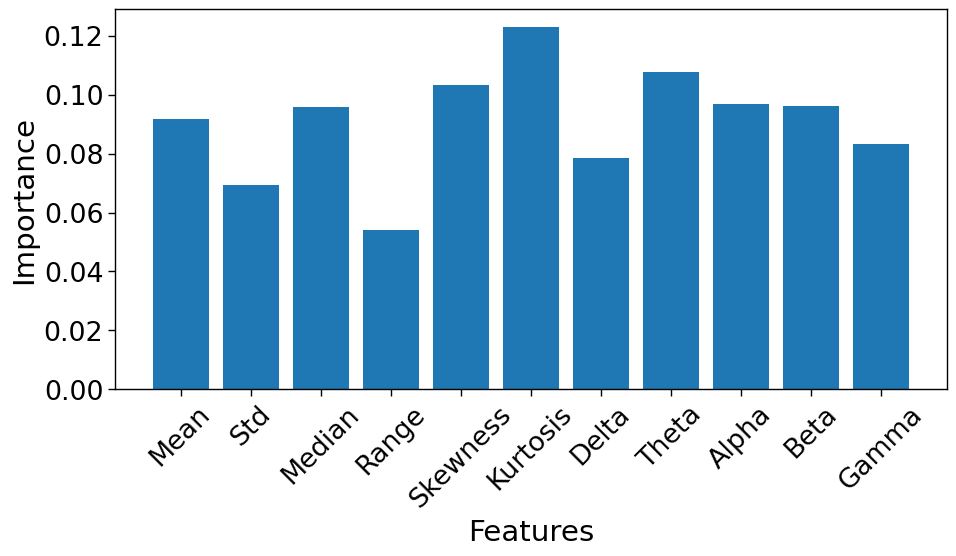

In [69]:
import matplotlib.pyplot as plt

feature_importances = xgb_classifier.feature_importances_
features_names = combined_df.columns  # Assuming combined_df contains the feature names
feature_importances_reshaped = np.array_split(feature_importances, len(features_names))

feature_importances_summed = [np.sum(importance) for importance in feature_importances_reshaped]

plt.figure(figsize=(10, 6))
plt.bar(features_names, feature_importances_summed)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('features_XGB.eps', format='eps')
plt.show()

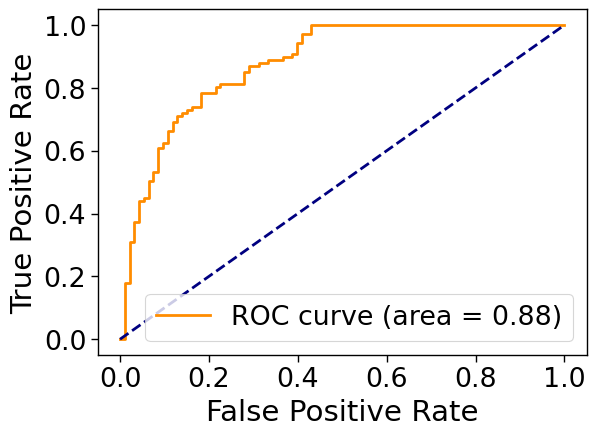

In [70]:
from sklearn.metrics import roc_curve, auc

y_prob = xgb_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('roc_XGB.eps', format='eps')
plt.show()

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = xgb_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Confusion Matrix:
 [[67 26]
 [16 91]]
Accuracy: 0.79
Precision: 0.7777777777777778
Recall: 0.8504672897196262
F1-score: 0.8125000000000001


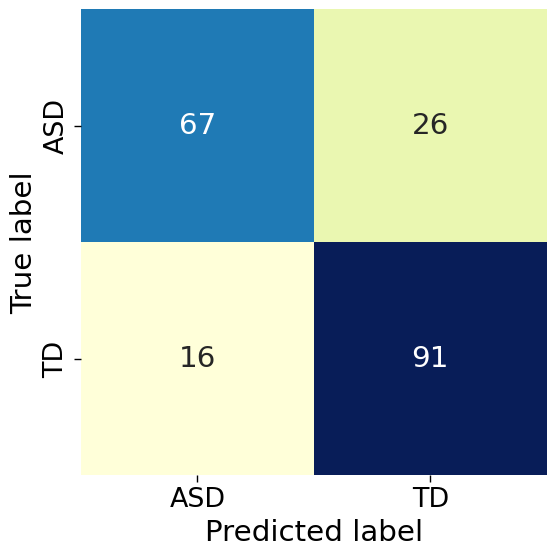

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
# sns.set_context('paper', font_scale=2.2)
sns.heatmap(conf_matrix, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=['ASD', 'TD'],
            yticklabels=['ASD', 'TD'],
            cbar=False)  # Remove the color bar
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('conf_XGB.eps', format='eps')
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error

y_pred_regression = xgb_classifier.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.21


In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error

""" Time domain features only """

reshaped_data = augmented_data.reshape(1000, 100, 11)
subset1 = reshaped_data[:, :, :6]
subset1_reshaped = subset1.reshape(1000, 600)

X_train, X_test, y_train, y_test = train_test_split(subset1_reshaped, augmented_labels, test_size=0.2, random_state=42)

xgb_classifier.fit(X_train, y_train)


y_pred = xgb_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

y_pred_regression = xgb_classifier.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Confusion Matrix:
 [[67 26]
 [13 94]]
Accuracy: 0.805
Precision: 0.7833333333333333
Recall: 0.8785046728971962
F1-score: 0.8281938325991189
Mean Squared Error: 0.195


In [75]:
""" Frequency domain features only """

reshaped_data = augmented_data.reshape(1000, 100, 11)
subset1 = reshaped_data[:, :, 6:11]
subset1_reshaped = subset1.reshape(1000, 500)

X_train, X_test, y_train, y_test = train_test_split(subset1_reshaped, augmented_labels, test_size=0.2, random_state=42)

xgb_classifier.fit(X_train, y_train)


y_pred = xgb_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

y_pred_regression = xgb_classifier.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Confusion Matrix:
 [[39 54]
 [51 56]]
Accuracy: 0.475
Precision: 0.509090909090909
Recall: 0.5233644859813084
F1-score: 0.5161290322580645
Mean Squared Error: 0.525
